In this Jupyter file, use of CNN architecure for Bone Break Classifiction has been demonstrated. 

The dataset is from Kaggle.  https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset

Above dataset has 10 classes. For each class a folder is available with subfolders as Test and Train. Total of 989 training images and 140 testing images are present. The images are of varying sizes, RGB in nature and .jpeg format.

In [ ]:
import os

#Load Kaggle credentials for downloading dataset
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ""
os.environ['KAGGLE_CACHE'] = ""
#%env KAGGLEHUB_CACHE="~\\.kaggle\\kaggle.json"

In [ ]:
#Download the dataset

import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/bone-break-classification-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\nvohr\.cache\kagglehub\datasets\pkdarabi\bone-break-classification-image-dataset\versions\4


In [ ]:
#Directory path in which folders and sub-folders for training/testing are present
dir_path = os.path.join(path, 'Bone Break Classification\Bone Break Classification')
dir_path

'C:\\Users\\nvohr\\.cache\\kagglehub\\datasets\\pkdarabi\\bone-break-classification-image-dataset\\versions\\4\\Bone Break Classification\\Bone Break Classification'

In [ ]:
#Create the lists with training and testing data & corresponding labels (class name)
import numpy as np
from PIL import Image

training_data = []          #List with Training data
training_labels = []        #List with Training data class label

testing_data = []           #List with Testing data
testing_labels = []         #List with Testing data class label

# As the data in present in folder/sub-folder structure, os.walk is used to scan through the dir-path and collect the images.
# Folder name is taken as class name
# Eg: Avulsion fracture (folder = class name)
#     ---- Test
#     ---- Train
for dirpath, dirnames, filenames in os.walk(dir_path): 
    for filename in filenames:
            if filename.endswith((".jpg", ".jpeg", ".png")): # Example image file extensions
                name_split = dirpath.split('\\')    #Split identifier is based on windows file name usage
                foldername = name_split[-1]         #Last string as folder (Test/Train)
                label = name_split[-2]              #Second last string as class label

                # Construct the full file path
                file_path = os.path.join(dirpath, filename)     

                try:
                    # Load data (e.g., image)
                    img = Image.open(file_path)
                    img_array = np.array(img)

                    #Based on folder name, add the data to corresponding list
                    if foldername == 'Test':
                        testing_data.append(img_array)
                        testing_labels.append(label)
                    else:
                        training_data.append(img_array)
                        training_labels.append(label)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")


In [99]:
print(len(training_data), len(training_labels))
print(len(testing_data), len(testing_labels))

989 989
140 140


In [ ]:
#Convert class labels to numeric labels (0-9)
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
training_labels_numeric = label_encoder.fit_transform(training_labels)
testing_labels_numeric = label_encoder.fit_transform(testing_labels)

# Mapping between numeric labels and class labels
integer_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(integer_mapping)

{np.int64(0): np.str_('Avulsion fracture'), np.int64(1): np.str_('Comminuted fracture'), np.int64(2): np.str_('Fracture Dislocation'), np.int64(3): np.str_('Greenstick fracture'), np.int64(4): np.str_('Hairline Fracture'), np.int64(5): np.str_('Impacted fracture'), np.int64(6): np.str_('Longitudinal fracture'), np.int64(7): np.str_('Oblique fracture'), np.int64(8): np.str_('Pathological fracture'), np.int64(9): np.str_('Spiral Fracture')}


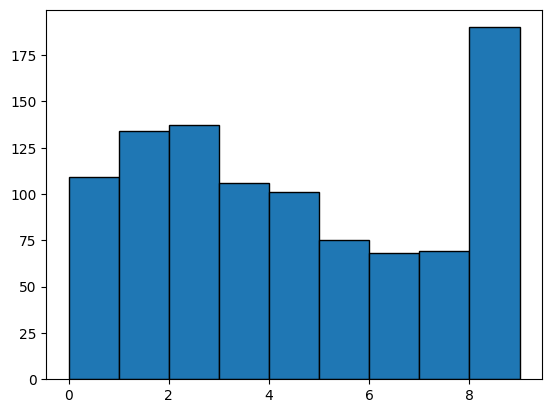

In [ ]:
#Histogram plot of Training data
import matplotlib.pyplot as plt

plt.hist(training_labels_numeric,bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], edgecolor="black")

plt.show()

In [ ]:
# Plot sample images for each class

def plot_sample_images(images, labels, class_names=None):
    """Plots sample images for each class.

    Args:
        images (list): List of image arrays.
        labels (list): List of corresponding labels.
        class_names (list, optional): List of class names for display. Defaults to None.
    """
    images_by_class = {}
    for i, label in enumerate(labels):
        if label not in images_by_class:
            images_by_class[label] = []
        images_by_class[label].append(images[i])

    num_classes = len(images_by_class)
    fig, axes = plt.subplots(1, num_classes, figsize=(20, 5)) #adjust figsize as needed

    for i, label in enumerate(images_by_class.keys()):
        sample_image = images_by_class[label][0] # Take the first image for each class
        if num_classes == 1:
           ax = axes
        else:
           ax = axes[i]
        ax.imshow(sample_image)
        if class_names:
            ax.set_title(class_names[label])
        else:
            ax.set_title(f"Class {label}")
        ax.axis('off')

    plt.show()

{'Fracture Dislocation', 'Hairline Fracture', 'Pathological fracture', 'Avulsion fracture', 'Comminuted fracture', 'Impacted fracture', 'Spiral Fracture', 'Longitudinal fracture', 'Greenstick fracture', 'Oblique fracture'}


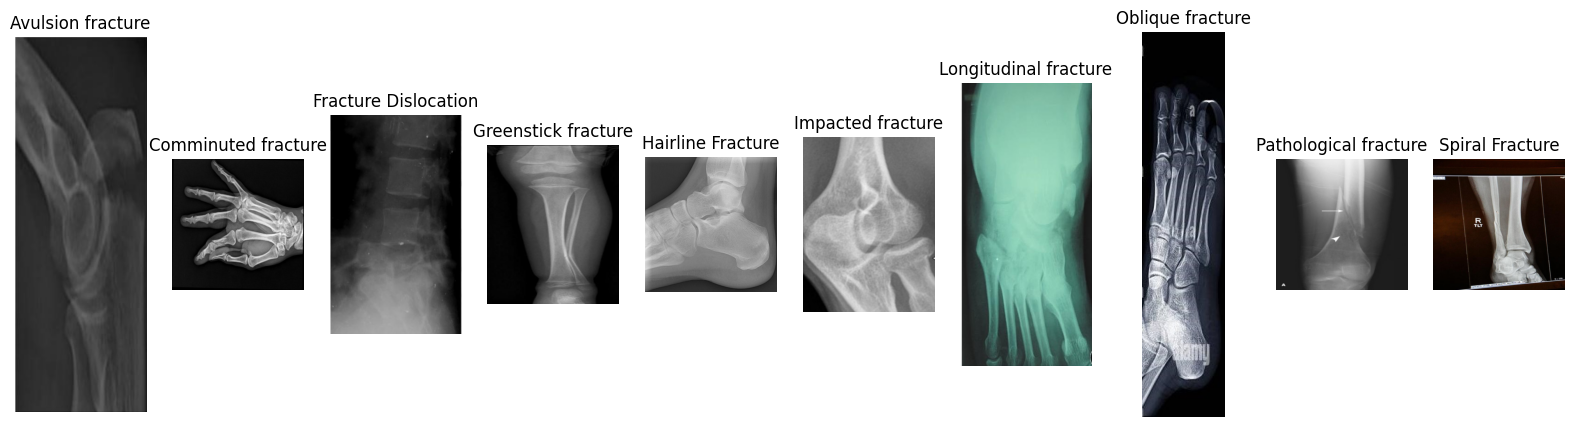

In [104]:
class_labels = set(training_labels)
print(class_labels)
plot_sample_images(training_data, training_labels_numeric, integer_mapping)

In [ ]:
#Split the training set into training and validation set
from sklearn.model_selection import train_test_split

X_train = training_data
y_train = training_labels_numeric

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Testing data
X_test = testing_data
y_test = testing_labels_numeric

CNN architecture for the dataset. 
- 3 convolutions layers
- 3 Fully connected layers
- 'Relu' as activation function
- Softmax for last layer
- Adam optimizer
- CrossEntropy Loss function

Experiments with early stopping and transformation on training data have also been tried. The accuracy, however, has not shown an improvement. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F

# Custom dataset for loading the images
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images   #ndarray
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
       
        if self.transform:
            image = self.transform(image)    #Apply transform on image

        label = self.labels[idx]        #Label of the image
        return image, label

In [ ]:
# Transformations for training and testing data

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 256x256 pixels
    #transforms.RandomRotation(degrees=10), # Randomly rotate up to 30 degrees
    #transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1), shear=0.1),
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor (values between 0 and 1)
])

# Don't augment test data, only reshape
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [111]:
# Create your custom dataset
train_dataset = CustomDataset(images=X_train, labels=y_train, transform=train_transform)
val_dataset = CustomDataset(images=X_val, labels=y_val, transform=train_transform)
test_dataset = CustomDataset(images=X_test, labels=y_test, transform=test_transform)

In [112]:
print(train_dataset.__len__())
print(val_dataset.__len__())
print(test_dataset.__len__())

791
198
140


In [113]:
#Setting datasetloader for training, validation and testing
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [114]:
# Example of iterating through dataloaders
for images, labels in train_dataloader:
    print("Training batch: ", images.shape, labels.shape)
    break

for images, labels in val_dataloader:
    print("Validation batch: ", images.shape, labels.shape)
    break

for images, labels in test_dataloader:
    print("Testing batch: ", images.shape, labels.shape)
    break

Training batch:  torch.Size([16, 3, 224, 224]) torch.Size([16])
Validation batch:  torch.Size([16, 3, 224, 224]) torch.Size([16])
Testing batch:  torch.Size([16, 3, 224, 224]) torch.Size([16])


CNN Module

In [115]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='valid')
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='valid')
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='valid')
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(26*26*128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26 * 26 * 128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Instantiating CNN model
model = CNN()

In [117]:
#Moding the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [118]:
#Setting Optimizer and Loss Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Early Stopping Function

In [119]:
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
                            Default: 4
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        elif self.best_loss - val_loss <= self.min_delta:
            print(self.best_loss - val_loss)
            self.counter += 1
            print(f"Early stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True


In [ ]:
#Defining function for training and validating the model in each epoch, measuing the accuracy
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, checkpoint_path="checkpoint.pth", early=False):
    # Instantiate early stopping
    if(early):
        early_stopping = EarlyStopping(patience=10, min_delta=0.001)

    #best_val_loss = float('inf')  # Initialize best validation loss
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Perform training
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Perform Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        # Check for early stopping
        if(early):
            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                break

        '''
        if avg_val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss
            }
            torch.save(checkpoint, checkpoint_path)
            print("Checkpoint saved.")
        '''

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


In [121]:
#Defining the evaluation mode for test images
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, test_loader, classes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Compute confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [122]:
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=30)

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
print("Training complete")

Epoch 1/30, Train Loss: 2.2892, Train Accuracy: 14.03%, Val Loss: 2.2967, Val Accuracy: 14.65%
Epoch 2/30, Train Loss: 2.2624, Train Accuracy: 14.29%, Val Loss: 2.3069, Val Accuracy: 12.12%
Epoch 3/30, Train Loss: 2.2268, Train Accuracy: 16.69%, Val Loss: 2.2680, Val Accuracy: 13.13%
Epoch 4/30, Train Loss: 2.2460, Train Accuracy: 16.43%, Val Loss: 2.2761, Val Accuracy: 15.15%
Epoch 5/30, Train Loss: 2.2194, Train Accuracy: 18.33%, Val Loss: 2.2538, Val Accuracy: 15.66%
Epoch 6/30, Train Loss: 2.1402, Train Accuracy: 21.49%, Val Loss: 2.3430, Val Accuracy: 12.63%
Epoch 7/30, Train Loss: 2.1183, Train Accuracy: 21.49%, Val Loss: 2.2635, Val Accuracy: 21.72%
Epoch 8/30, Train Loss: 2.0264, Train Accuracy: 25.92%, Val Loss: 2.3395, Val Accuracy: 17.17%
Epoch 9/30, Train Loss: 1.9591, Train Accuracy: 28.70%, Val Loss: 2.2700, Val Accuracy: 20.20%
Epoch 10/30, Train Loss: 1.8335, Train Accuracy: 35.15%, Val Loss: 2.3432, Val Accuracy: 21.21%
Epoch 11/30, Train Loss: 1.7292, Train Accuracy: 

In [123]:
classes = [str(integer_mapping[i]) for i in range(10)]
classes


['Avulsion fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

d:\trypy12\campusx-object-detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\trypy12\campusx-object-detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\trypy12\campusx-object-detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

Test Accuracy: 0.1714, Precision: 0.1730, Recall: 0.1714, F1-Score: 0.1518
Confusion Matrix:
[[3 3 3 3 1 0 0 0 1 0]
 [1 3 6 2 0 0 0 0 2 0]
 [2 2 7 2 5 0 0 0 1 0]
 [1 7 1 5 2 0 0 0 0 0]
 [3 2 2 1 1 0 0 1 0 0]
 [1 1 3 0 3 0 0 0 1 0]
 [1 1 2 4 0 0 0 1 2 1]
 [3 2 5 1 3 0 1 0 1 0]
 [2 7 2 0 0 0 2 1 4 0]
 [2 4 2 2 0 0 1 0 0 1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.21      0.18        14
           1       0.09      0.21      0.13        14
           2       0.21      0.37      0.27        19
           3       0.25      0.31      0.28        16
           4       0.07      0.10      0.08        10
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        16
           8       0.33      0.22      0.27        18
           9       0.50      0.08      0.14        12

    accuracy                           0.17       140
  

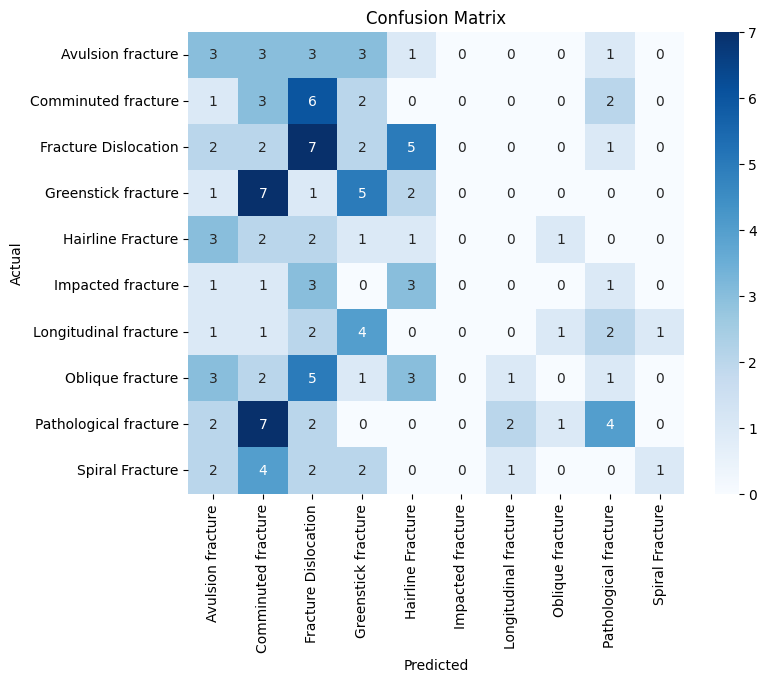

In [ ]:
# Evaluate model on test data

evaluate_model(model, test_dataloader, classes)